In [264]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 3.17 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [265]:
src = f"/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)


In [266]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (4000, 8, 70, 3, 6)
b (4000, 8, 70, 3, 6)
L (4000, 8, 70, 3, 6)
ℓ (4000, 8, 70, 3, 6)
H (4000, 8, 70, 3, 6)


In [267]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))

a = posterior_samples[site.a]
subjects = df['participant'].unique()
subjects = sorted(encoder_dict['participant'].inverse_transform(subjects))
positions = sorted(df['compound_position'].unique())
subjects = sorted(df['participant'].unique())
sizes = sorted(df['compound_size'].unique())
muscles = model.response

In [268]:
positions

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69]

In [269]:
p1 = positions[:6]
p2 = positions[6:12]
keys = [p1, p2]

In [270]:
a.shape

(4000, 8, 70, 3, 6)

In [271]:
test = a[:,0,(1,2), 0,...]

In [272]:
test[:,0,...].shape

(4000, 6)

In [273]:
muscles = model.response

In [274]:
encoder_dict[model.features[2]].inverse_transform([0,1,2])

array(['B', 'S', 'S-B'], dtype=object)

In [275]:
keys

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]

In [276]:
sizes = sizes[:2]

In [277]:
sizes

[0, 1]

In [278]:
norm_y = []
norm_x = []
size_ind = 0
target_compound = 5

for subject_ind, subject in enumerate(subjects):
    for k in keys:
        for s in sizes:
            for m_ind, m in enumerate(muscles):
            # Fix the subject index and size index
                a_temp = a[:, subject_ind, k, :2, m_ind]
                mean_thres = np.nanmean(a_temp[:,target_compound,...],axis=(0,-1))
                curr_params = [
                    params[:, subject_ind, k, s, m_ind, None] for params in params
                ]
                
                x_temp = np.array([1.2*mean_thres])[None, None, None,None,None,:]

                temp_thresh = F.rectified_logistic(
                    x_temp, #x_temp
                    *curr_params
                )
                
                # Remove offset
                temp_thresh = temp_thresh - curr_params[2]
                norm_y.append(temp_thresh)
                norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(keys), len(sizes), len(muscles), *norm_x.shape[4:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects), len(keys), len(sizes), len(muscles), *norm_y.shape[4:])
norm_y = ma.masked_invalid(norm_y)


In [279]:
norm_y.shape

(8, 2, 2, 6, 4000, 6, 1)

In [280]:
big = norm_y[:,:,0,...]
small = norm_y[:,:,1,...]

In [281]:
big.shape

(8, 2, 6, 4000, 6, 1)

In [282]:
big_ind = [0,1,2,2,5]
small_ind = [0,1,3,4,5]

# Threshold

In [283]:
keys

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]

In [39]:
compound_position[:12]

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M'], dtype=object)

In [284]:
test_keys = [[0, 1, 2, 5], [6, 7, 8, 11]]

In [285]:
big_keys = [[0, 1, 2,2, 5]]
small_keys = [[0, 1, 3,4, 5]]

In [286]:
a.shape

(4000, 8, 70, 3, 6)

In [287]:
norm_a = a[:,:,:6,:2,:]
norm_a = ma.masked_invalid(norm_a)


In [288]:
encoder_dict[model.features[2]].inverse_transform([0,1])

array(['B', 'S'], dtype=object)

In [289]:
norm_a = norm_a / ma.median(norm_a, axis=(2,3,4), keepdims=True)

In [290]:
norm_a.mean()

1.2516987252114729

In [291]:
arr_big = []
size_ind = 0

for subject_ind, subject in enumerate(subjects):
    for k in big_keys:
        a_temp = norm_a[:, subject_ind, k, size_ind,:]
        arr_big.append(a_temp)
arr_big = np.array(arr_big)
arr_big = arr_big.reshape(len(subjects), 1, *arr_big.shape[1:])

In [292]:
arr_small = []
size_ind = 1

for subject_ind, subject in enumerate(subjects):
    for k in small_keys:
        a_temp = norm_a[:, subject_ind, k, size_ind,:]
        arr_small.append(a_temp)
arr_small = np.array(arr_small)
arr_small = arr_small.reshape(len(subjects), 1,*arr_small.shape[1:]) 

In [293]:
arr_big = ma.masked_invalid(arr_big)

In [294]:
arr_small.shape

(8, 1, 4000, 5, 6)

In [295]:
arr_small = ma.masked_invalid(arr_small)

In [296]:
arr_mean_big = ma.mean(arr_big, axis=(2))
arr_mean_small = ma.mean(arr_small, axis=(2))

In [297]:
arr_mean_big.shape

(8, 1, 5, 6)

In [189]:
arr_mean_big.mean(axis = (1,2,3))

masked_array(data=[1.5292989905242456, 1.0947209476932058,
                   1.203840960193263, 1.1891059390185965,
                   1.079158911141215, --, 0.4768540221896835,
                   0.8606394086255252],
             mask=[False, False, False, False, False,  True, False, False],
       fill_value=1e+20)

In [298]:
arr_mean_big_lat = ma.mean(arr_mean_big,axis = (1,3))

In [334]:
arr_mean_small_lat = ma.mean(arr_mean_small,axis = (1,3))

In [335]:
arr_mean_small_lat.shape

(8, 5)

In [301]:
arr_mean_big_lat = arr_mean_big_lat[:,(0,1,2,4)]

In [305]:
t = arr_mean_big_lat[:,:,None] - arr_mean_big_lat[:,None,:]
t.shape

(8, 4, 4)

In [313]:
arr_mean_big_lat.shape

(8, 4)

In [315]:
stats.sem(arr_mean_big_lat,axis=0)

array([0.08279817, 0.47628799, 0.11802534, 0.23283615])

In [306]:
pval = []
for i in range(t.shape[1]):
    for j in range(t.shape[2]):
        if i==j:
            pval.append(1)
        else:
            pval.append(stats.wilcoxon(t[:,i,j])[1])

In [307]:
pval

[1,
 0.125,
 0.875,
 0.3125,
 0.125,
 1,
 0.125,
 0.8125,
 0.875,
 0.125,
 1,
 0.375,
 0.3125,
 0.8125,
 0.375,
 1]

In [190]:
diff = arr_mean_big - arr_mean_small

In [191]:
diff.shape

(8, 1, 5, 6)

In [192]:
t = diff[:, :, [0, 2, 3,], :].mean(axis=( 2, 3))
t.mean(axis=0)

masked_array(data=[-0.7428334203207084],
             mask=[False],
       fill_value=1e+20)

In [193]:
stats.wilcoxon(t, axis=0)

WilcoxonResult(statistic=array([0.]), pvalue=array([0.0625]))

In [129]:
stats.sem(t, axis=0)

array([22.32596078, 29.09513637])

In [98]:
diff.shape

(8, 2, 4, 6)

In [122]:
diff = ma.mean(diff, axis=(2,-1))

In [100]:
diff.shape

(8,)

In [101]:
diff.mean()

-6.84646236034372

In [102]:
stats.sem(diff, axis=0)

12.309682126329713

In [131]:
stats.ttest_1samp(t, axis=0, popmean=0)

TtestResult(statistic=array([-3.45319153,  0.3594051 ]), pvalue=array([0.02597864, 0.75369181]), df=array([4., 2.]))

In [121]:
t.mask

array([False, False, False,  True,  True,  True, False, False])

In [115]:
stats.wilcoxon(t, axis=0).pvalue

0.0625

In [49]:
labels = ['L', 'LL', 'LM1','LM2', 'M']
pvalues = []
for i in range(len(labels)):
    temp_p = stats.wilcoxon(diff, axis=0).pvalue
    pvalues.append(temp_p)

In [263]:
pvalues

NameError: name 'pvalues' is not defined

In [194]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/cst_selectivity_means.pkl"
with open(src, "rb") as f:
    selectivity_small, selectivity_big = pickle.load(f)

In [195]:
selectivity_small

masked_array(
  data=[[[0.6739609881646469, 0.9522769464308535, 0.6479455145851215,
          0.5715017805069169, 0.45693566920187084],
         [--, --, --, --, --]],

        [[0.9835957532553877, 0.9138785863420731, 1.1965049346870265,
          0.9317709058951679, 1.1610791553503],
         [--, --, --, --, --]],

        [[0.698850038990781, 0.931095944421215, 0.6560475793777696,
          0.6292440972696213, 0.6078576090069514],
         [1.0291184185076685, 1.1490362335236872, 0.9478503543146524,
          0.9199218781978135, 0.7179134325274739]],

        [[1.1820277764933398, 1.2665546574294646, 1.4271071605632932,
          1.2465028843196695, 0.8298234887150198],
         [0.8860989751630272, 1.0763225573571016, 0.9177889778071827,
          0.8261610852086686, 0.6206938515697028]],

        [[0.778457517828389, 0.754068415352096, 0.8967727317592703,
          0.8422666722386505, 0.7792464260518837],
         [0.5345742340749557, 0.6045693796572372, 0.7215752090099784,
     

In [196]:
arr_mean_big.shape

(8, 1, 5, 6)

In [197]:
combined = np.concatenate([arr_mean_small[...,None], arr_mean_big[ ...,None]], axis=4) 

In [198]:
arr_mean_small[0,0,0,0]

0.614797253069905

In [199]:
combined.shape

(8, 1, 5, 6, 2)

In [200]:
small = combined[...,0]

In [201]:
big = combined[...,1]

In [202]:
small_mean = ma.mean(small, axis=(1,-1))

In [203]:
big_mean = ma.mean(big, axis=(1,-1))

In [204]:
big_mean.shape

(8, 5)

In [317]:
arr_mean_big_lat.shape

(8, 4)

In [205]:
inds = [0,1,2,4]

In [206]:
big_mean = big_mean[:,inds]

In [207]:
big_mean.shape

(8, 4)

In [318]:
big_diff = arr_mean_big_lat[:,:,None] - arr_mean_big_lat[:,None,:]

In [209]:
small_diff = small_mean[:,:,None] - small_mean[:,None,:]

In [210]:
small_diff.shape

(8, 5, 5)

In [214]:
avg_small = ma.mean(combined[...,0], axis=(0,1,-1))
avg_big = ma.mean(combined[...,1], axis=(0,1,-1))

avg_sel_small = ma.mean(selectivity_small[:,0,:], axis=(0))
avg_sel_big = ma.mean(selectivity_big[:,0,:], axis=(0))

In [212]:
combined.shape

(8, 1, 5, 6, 2)

In [215]:
selectivity_small.shape

(8, 2, 5)

In [ ]:
sem_eff_big = []
sem_sel_big = []
for i in range(len(combined[0,0,:,0,0])):
    sem_eff_big.append(ma.std(combined[:,:,i,:,1]) / ma.sqrt(ma.count(combined[:,:,i,:,1])))
    sem_sel_big.append(ma.std(selectivity_big[:,0,i]) / ma.sqrt(ma.count(selectivity_big[:,0,i])))
    
sem_eff_small = []
sem_sel_small = []
for i in range(len(combined[0,0,:,0,0])):
    sem_eff_small.append(ma.std(combined[:,:,i,:,0]) / ma.sqrt(ma.count(combined[:,:,i,:,0])))
    sem_sel_small.append(stats.sem(selectivity_small[:,0,i]))

In [217]:
plot_big_inds = (0,1,2,4)

In [221]:
avg_big = np.delete(avg_big, 3)

In [223]:
avg_sel_big= np.delete(avg_sel_big, 3)
sem_sel_big = np.delete(sem_sel_big, 3)
sem_eff_big = np.delete(sem_eff_big, 3)

In [222]:
avg_big

masked_array(data=[0.40137664, 1.34881412, 0.34552956, 1.05320254],
             mask=False,
       fill_value=1e+20)

In [224]:
avg_small

masked_array(data=[1.24796101, 1.48538088, 1.23198782, 1.20739475,
                   1.53548012],
             mask=False,
       fill_value=1e+20)

In [320]:
arr_mean_big_lat.shape

(8, 4)

In [336]:
avg_small = ma.mean(arr_mean_small_lat, axis=0)


In [337]:
1/avg_small

masked_array(data=[0.8013070856549563, 0.6732279995332888,
                   0.8116963355588142, 0.8282295382156813,
                   0.6512620939202197],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [338]:
sem_eff_small = stats.sem(arr_mean_small_lat, axis=0)

In [339]:
sem_eff_small

array([0.20521223, 0.25686986, 0.2113423 , 0.15182129, 0.17504015])

In [340]:
sem_sel_small = stats.sem(selectivity_small[:,0,:], axis=0)

In [346]:
sem_sel_big = stats.sem(selectivity_big[:,0,(0,1,3,4)], axis=0)

In [347]:
sem_sel_big.shape

(4,)

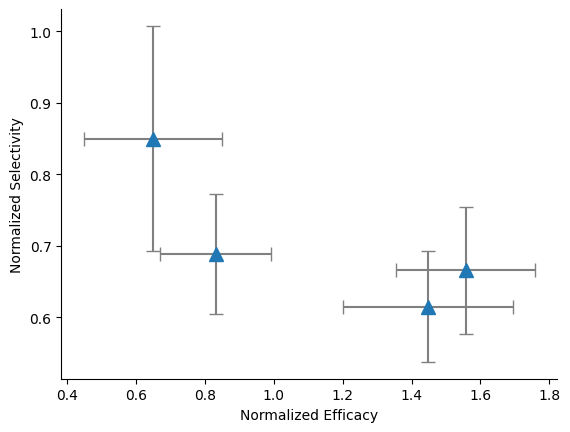

In [348]:
plt.errorbar(x=1/avg_big, y=avg_sel_big, yerr=sem_sel_big, xerr=(sem_eff_big/avg_big**2), fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()

In [227]:
diff.shape

(8, 1, 5, 6)

In [228]:
diff_sel = selectivity_big[:,0,:] - selectivity_small[:,0,:]

In [259]:
diff_sel[:,(0,2,3)].shape

(8, 3)

In [261]:
diff_sel[:,(0,2,3)].mean(axis = 1)

masked_array(data=[-0.15557439819350102, -0.46546639940704476,
                   -0.2704087558144766, --, --, --, 0.1569912398675787,
                   -0.5709378793527331],
             mask=[False, False, False,  True,  True,  True, False, False],
       fill_value=1e+20)

In [262]:
stats.wilcoxon(diff_sel[:,(0,2,3)].mean(axis = 1), axis=0)

WilcoxonResult(statistic=2.0, pvalue=0.1875)

In [230]:
diff_eff = ma.mean(diff, axis=(1,-1))

In [234]:
diff_eff.shape

(8, 5)

In [250]:
avg_diff_sel = ma.mean(diff_sel, axis=0)
avg_diff_eff = ma.mean(diff_eff, axis=0)
sem_diff_sel = stats.sem(diff_sel, axis=0)
sem_diff_eff = stats.sem(diff_eff, axis=0)

In [251]:
avg_diff_eff

masked_array(data=[-0.7809718606794567, 0.029644101549534944,
                   -0.7648537083177461, -0.6488356067229413,
                   -0.355794767869014],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [253]:
avg_diff_sel

masked_array(data=[-0.20278201759111258, -0.13973094115798565,
                   -0.3044647425502673, -0.2859005022287363,
                   -0.06628877694547428],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

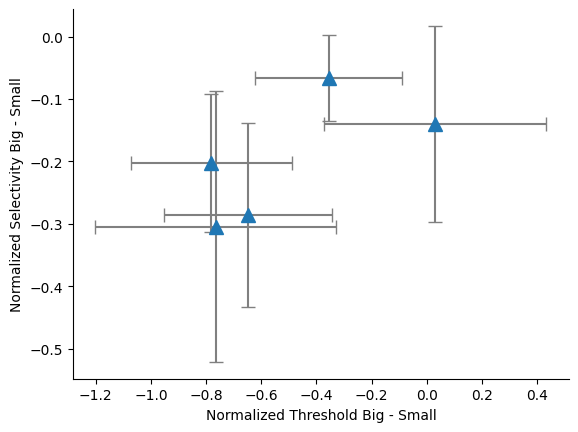

In [252]:
plt.errorbar(x=avg_diff_eff, y=avg_diff_sel, yerr=sem_diff_sel, xerr=sem_diff_eff, fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Threshold Big - Small")
plt.ylabel("Normalized Selectivity Big - Small")
sns.despine()

# Old

In [ ]:
means_a = ma.mean(arr_diffs, axis=(1,-1))

In [ ]:
means_a.shape

(8, 5, 5)

In [ ]:
compound_position

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [ ]:
labels = ['L', 'LL', 'LM', 'M']
pvalues = []
for i in range(len(labels)):
    for i2 in range(len(labels)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(means_a[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(labels), len(labels))

<Axes: >

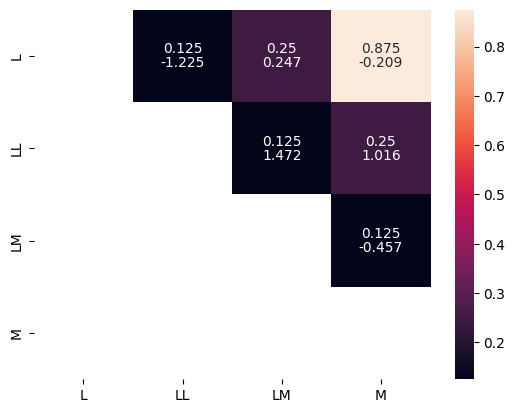

In [ ]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(means_a.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

# MEP amp

In [ ]:
c5_big = a[:,:,p1,0,:]
c6_big = a[:,:,p2,0,:]

In [141]:
big.shape

(8, 2, 6, 6)

In [140]:
big = ma.mean(big, axis=(3,5))

In [143]:
small.shape

(8, 2, 6, 6)

In [142]:
small = ma.mean(small, axis=(3,5))

In [142]:
big.shape

(8, 2, 6, 400, 6, 1)

In [144]:
big = big[:,:,:,big_ind]
small = small[:,:,:,small_ind]

In [145]:
diffs = big - small

In [146]:
diffs.shape

(8, 2, 6, 5)

In [147]:
diffs_mean = ma.mean(diffs, axis=(1,2,3))

In [148]:
stats.wilcoxon(diffs_mean, axis=0)

WilcoxonResult(statistic=4.0, pvalue=0.109375)

In [ ]:
means_c5 = ma.mean(norm_y[:,0,...], axis=(2,4))
means_c6 = ma.mean(norm_y[:,1,...], axis=(2,4))

means_c5_diff = means_c5[:,:,None] - means_c5[:,None,:]
means_c6_diff = means_c6[:,:,None] - means_c6[:,None,:]

In [ ]:
means_c5_diff = means_c5[:,:,:,None] - means_c5[:,:,None,:]
means_c6_diff = means_c6[:,:,:,None] - means_c6[:,:,None,:]

In [ ]:
means_c5_diff.shape

(8, 6, 6, 6)

In [ ]:
means_c6.shape

(8, 6, 6)

In [ ]:
t = ma.mean(ma.array([means_c5_diff, means_c6_diff]), axis=(0))

In [ ]:
t.shape

(8, 6, 6, 6)

In [ ]:
stats.wilcoxon(t[:,4, 0, 5], axis=0)

WilcoxonResult(statistic=array([6.]), pvalue=array([0.109375]))

In [ ]:
t = ma.mean(t, axis=1)

In [ ]:
t.shape

(8, 6, 6)

<Axes: >

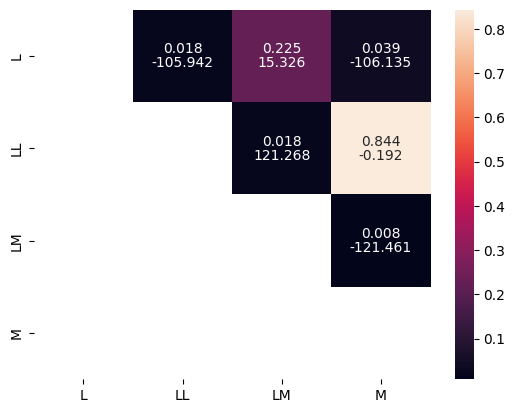

In [155]:
pvalues = []
for i in range(4):
    for i2 in range(4):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(big_diff[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(4, 4)

labels = ['L', 'LL', 'LM', 'M']
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(big_diff.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [ ]:
t.shape

(8, 6, 6)